# Setup: Installations and imports

Save installations to drive to avoid repeating installations in the future

In [ ]:
!pip install llama-cpp-python -q
!pip install mlflow -q
!pip install pyngrok -q
!pip install evaluate -q
!pip install bert-score -q

In [1]:
# Importing necessary libraries for general data handling
import pandas as pd
import pickle
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# Importing necessary libraries for model interaction
from llama_cpp import Llama

# Importing necessary libraries for mlflow interaction
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

# Importing necessary libraries for the BERT metric
import evaluate
import bert_score

# Importing necessary libraries for the LLMaaJ metric
import os
import openai

In [2]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Hosting MLFlow in Colab via Ngrok

In [ ]:
# Define the MLflow tracking URI with SQLite
# MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
MLFLOW_TRACKING_URI = "file:///content/mlruns"

# Start the MLflow server using subprocess
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5000"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'file...>

In [ ]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# Set or create an experiment
mlflow.set_experiment("Translation Tasks")

print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Tracking URI: file:///content/mlruns


In [ ]:
# Set up ngrok for exposing the MLflow UI
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


In [ ]:
# Expose the MLflow UI on port 5000
port = 5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

 * ngrok tunnel "https://927b-34-145-87-0.ngrok-free.app" -> "http://127.0.0.1:5000"




---



# Running the pipeline

## Install the models, import the data

In [ ]:
# Load Gemma 2B model
llm_gemma2b = Llama.from_pretrained(
	repo_id="lmstudio-ai/gemma-2b-it-GGUF",
	filename="gemma-2b-it-q8_0.gguf",
	n_ctx=1024,
)

In [ ]:
# Load Llama3.2 3B model
llm_llama3b = Llama.from_pretrained(
	repo_id="hugging-quants/Llama-3.2-3B-Instruct-Q8_0-GGUF",
	filename="llama-3.2-3b-instruct-q8_0.gguf",
	n_ctx=1024,
)

In [ ]:
# Load Bartowski 35B model
llm_llama8b = Llama.from_pretrained(
	repo_id="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
	filename="Meta-Llama-3.1-8B-Instruct-Q5_K_M.gguf",
  	n_ctx=1024,
)

In [ ]:
# Load 35b model
llm_bartowski35b = Llama.from_pretrained(
	repo_id="bartowski/aya-23-35B-GGUF",
	filename="aya-23-35B-Q5_K_M.gguf",
  	n_ctx=1024,
	n_gpu_layers=-1,
)

In [ ]:
# Read in given text files (5 complexities x 2 languages)
input = pd.read_pickle("machine_translation.pkl")

input.head()

complexity                                        text_german  \
0         easy  Felix hat es satt: Ständig ist Mama unterwegs....   
1     news_gen  Die rund 1.400 eingesetzten Beamten haben demn...   
2    news_spec  Der Staatschef hat zugleich aber das Recht, vo...   
3  pop_science  Dass der Klimawandel die Hitzewellen in Südasi...   
4      science  Der DSA-110, der sich am Owens Valley Radio Ob...   

                                        text_english  
0  Felix is fed up: Mom is always on the go. But ...  
1  The approximately 1,400 deployed officers have...  
2  The head of state also has the right to appoin...  
3  There is no question that climate change is in...  
4  The DSA-110, situated at the Owens Valley Radi...

## Generate the prompts, create the experiment dataset

In [ ]:
# Define the prompts for both translation directions before the loop
prompts_DEtoENG = [
    [
      f"Translate the following German text to English. Be precise. Only output the translated text. German:\n\n{text}\n\nEnglish translation:",
      f"Translate the following German text to English. Be precise. Examples:\n\
        1. German text: 'Der kleine Hund spielte im Garten, während die Kinder fröhlich lachten.' English translation: 'The little dog played in the garden while the children laughed happily.'\
        2. German text: 'Die Regierung erklärte, dass die neuen Maßnahmen, die in Zusammenarbeit mit internationalen Experten entwickelt wurden, ab nächster Woche gelten sollen, obwohl einige Kritiker ihre Wirksamkeit infrage stellen.' English translation: 'The government stated that the new measures, which were developed in collaboration with international experts, will take effect next week, although some critics question their effectiveness.'\
        3. German text: 'Die Ergebnisse der umfassenden Langzeitstudie, die über einen Zeitraum von zehn Jahren durchgeführt wurde, zeigen, dass eine gezielte Erhöhung der Proteinaufnahme in Kombination mit regelmäßiger körperlicher Aktivität die Muskelregeneration nach intensivem Training signifikant verbessern und gleichzeitig das Risiko von Verletzungen verringern kann.' English translation: 'The results of the comprehensive long-term study, conducted over a period of ten years, show that a targeted increase in protein intake combined with regular physical activity can significantly enhance muscle recovery after intensive training while simultaneously reducing the risk of injuries.'\n\
        Now, translate the following German text to English. Be precise. Only output the translated text. German text:\n\n{text}\n\nEnglish translation:"
    ]
    for text in input['text_german']
]

prompts_ENGtoDE = [
    [
      f"Translate the following English text to German. Be precise. Only output the translated text. English:\n\n{text}\n\nGerman translation:",
      f"Translate the following English text to German. Be precise. Examples:\n\
        1. English text: 'The little dog played in the garden while the children laughed happily.' German translation: 'Der kleine Hund spielte im Garten, während die Kinder fröhlich lachten.'\
        2. English text: 'The government stated that the new measures, which were developed in collaboration with international experts, will take effect next week, although some critics question their effectiveness.' German translation: 'Die Regierung erklärte, dass die neuen Maßnahmen, die in Zusammenarbeit mit internationalen Experten entwickelt wurden, ab nächster Woche gelten sollen, obwohl einige Kritiker ihre Wirksamkeit infrage stellen.'\
        3. English text: 'The results of the comprehensive long-term study, conducted over a period of ten years, show that a targeted increase in protein intake combined with regular physical activity can significantly enhance muscle recovery after intensive training while simultaneously reducing the risk of injuries.' German translation: 'Die Ergebnisse der umfassenden Langzeitstudie, die über einen Zeitraum von zehn Jahren durchgeführt wurde, zeigen, dass eine gezielte Erhöhung der Proteinaufnahme in Kombination mit regelmäßiger körperlicher Aktivität die Muskelregeneration nach intensivem Training signifikant verbessern und gleichzeitig das Risiko von Verletzungen verringern kann.'\n\
        Now, translate the following English text to German. Be precise. Only output the translated text. English text:\n\n{text}\n\German translation:"
    ]
    for text in input['text_english']
]

In [ ]:
# Define dictionary with pointers to the loaded models
models = {
    "llm_gemma2b": llm_gemma2b,
    "llm_llama3b": llm_llama3b,
    "llm_llama8b": llm_llama8b,
    "llm_bartowski35b": llm_bartowski35b,
}

# Create full dataframe with one row per sample of the experiment
# (5 complexities x 2 directions x 2 prompting techniques x 4 models)
rows = []
for idx, row in input.iterrows():
    for model_name in models.keys():
        # Add prompts for German to English
        for i, prompt in enumerate(prompts_DEtoENG[idx]):
            rows.append({
                "complexity": row["complexity"],
                "direction": "de->en",
                "text_german": row["text_german"],
                "text_english": row["text_english"],
                "prompt": prompt,
                "prompt_type": "zero-shot" if i == 0 else "few-shot",
                "model": model_name,
            })
        # Add prompts for English to German
        for i, prompt in enumerate(prompts_ENGtoDE[idx]):
            rows.append({
                "complexity": row["complexity"],
                "direction": "en->de",
                "text_german": row["text_german"],
                "text_english": row["text_english"],
                "prompt": prompt,
                "prompt_type": "zero-shot" if i == 0 else "few-shot",
                "model": model_name,
            })

# Create the final dataframe
df_prompts = pd.DataFrame(rows)

In [ ]:
# Preview the dataframe
df_prompts.head(20)

## Model interaction: call the model and save the experiment dataset

In [ ]:
#
def call_model(prompt, model_name):
    model = models[model_name]
    response = model(prompt=prompt, max_tokens=None)
    return response["choices"][0]["text"]


# Check if cached translations file exists
try:
    with open('full_cached_translations.pkl', 'rb') as f:
        translations = pickle.load(f)
    df_prompts = pd.read_pickle("full_cached_translations.pkl")
    print("Loaded cached translations.")
except FileNotFoundError:
    # If no cached translations exist, run the model
    translations = {}
    for idx, row in tqdm(df_prompts.iterrows(), total=len(df_prompts)):
        if pd.isna(row.get('translation')):
            translation = call_model(row['prompt'], row['model'])
            translations[(row['model'], row['prompt'])] = translation
            df_prompts.at[idx, 'translation'] = translation

        # Save the translations as a pickle file for later use
        cached_translations = "cached_translations.pkl"
        df_prompts.to_pickle(cached_translations)
        print(f"Saved translations to {cached_translations}.")

Loaded cached translations.


In [ ]:
df_prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   complexity    80 non-null     object
 1   direction     80 non-null     object
 2   text_german   80 non-null     object
 3   text_english  80 non-null     object
 4   prompt        80 non-null     object
 5   prompt_type   80 non-null     object
 6   model         80 non-null     object
 7   translation   80 non-null     object
dtypes: object(8)
memory usage: 5.1+ KB


## Alternatively load cached translations from previous run

In [ ]:
cached_translations_raw = pd.read_pickle("full_cached_translations_raw.pkl")
cached_translations_cleaned = pd.read_pickle("full_cached_translations_cleaned.pkl")

## Prepare the evaluation in MLFlow

### Creating custom metric for the BERT score

In [ ]:
# Function to calcuate BERT recall score based on given candidate (predictions) and reference (targets) values
def calculate_bert_precision_score(predictions, targets):
  result = []

  for i, (prediction, target) in enumerate(zip(predictions, targets)):
    P, R, F1 = bert_score.score([prediction], [target], lang="en", model_type="bert-base-uncased")
    result.append(R.item())

  return mlflow.metrics.MetricValue(
        scores=result,
    )

In [ ]:
# Creating mlflow metric based on the BERT score calculation function
bert_score_metric = mlflow.metrics.make_metric(eval_fn=calculate_bert_precision_score, greater_is_better=True, name="bert_score")

### Creating a custom answer similarity metric (LLM as a Judge) based on the pre-implemented mlflow metric by including finer graduated scoring rubrics and examples accordingly



In [ ]:
# Store OpenAI API key as environment variable
os.environ['OPENAI_API_KEY'] = ''

# Set OpenAI key
openai.api_key = os.environ['OPENAI_API_KEY']
if not openai.api_key:
    raise ValueError("OpenAI API key is not set. Please set the environment variable OPENAI_API_KEY.")

In [ ]:
# Import mlflow methods to create custom LLMaaJ metric
from mlflow.metrics.genai.base import EvaluationExample
from mlflow.metrics.genai.genai_metric import make_genai_metric
from mlflow.metrics.genai.utils import _get_latest_metric_version
from mlflow.models import EvaluationMetric
from mlflow.utils.class_utils import _get_class_from_string

In [ ]:
# Fetch current name and version of existing answer_similarity metrics
metric_version = _get_latest_metric_version()
class_name = f"mlflow.metrics.genai.prompts.{metric_version}.AnswerSimilarityMetric"

In [ ]:
# Fetch additional information of answer_similarity class
answer_similarity_class_module = _get_class_from_string(class_name)

In [ ]:
# Display current grading prompt of answer_similarity
answer_similarity_class_module.grading_prompt

'Answer similarity: Below are the details for different scores:\n- Score 1: The output has little to no semantic similarity to the provided targets.\n- Score 2: The output displays partial semantic similarity to the provided targets on some aspects.\n- Score 3: The output has moderate semantic similarity to the provided targets.\n- Score 4: The output aligns with the provided targets in most aspects and has substantial semantic similarity.\n- Score 5: The output closely aligns with the provided targets in all significant aspects.'

In [ ]:
# Define new grading prompt with larger grading rubric
updated_grading_prompt = 'Answer similarity: Below are the details for different scores:\n- Score 1: The output has little to no semantic similarity to the provided targets.\n- Score 2: The output contains only a minimal amount of relevant information but mostly diverges from the target in meaning and key details.\n- Score 3: The output captures a few relevant aspects of the target but lacks completeness and coherence in conveying the intended meaning.\n- Score 4: The output demonstrates moderate semantic similarity, covering some key ideas but missing critical elements or introducing inaccuracies.\n- Score 5: The output aligns with the provided target in a majority of aspects but lacks some depth or precision in certain details.\n- Score 6: The output is largely aligned with the target, covering most key details, with minor omissions or slight inaccuracies.\n- Score 7: The output is very close to the target, containing almost all essential information, with only minor rewording or slight lack of nuance.\n- Score 8: The output is highly similar to the target, with strong semantic alignment and only minimal rephrasing or minor missing details.\n- Score 9: The output is nearly identical in meaning to the target, with only trivial differences in wording or phrasing.\n- Score 10: The output closely aligns with the provided targets in all significant aspects, effectively conveying the intended meaning with precision and completeness.'

In [ ]:
# Display current scoring examples of answer_similarity
answer_similarity_class_module.default_examples

[EvaluationExample(output='MLflow is an open-source platform.', score=2, justification="The provided output is partially similar to the target, as it captures the general idea that MLflow is an open-source platform. However, it lacks the comprehensive details and context provided in the target about MLflow's purpose, development, and challenges it addresses. Therefore, it demonstrates partial, but not complete, semantic similarity.", input='What is MLflow?', grading_context={'targets': 'MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models.'}),
 EvaluationExample(output='MLflow is an open-source platform for managing machine learning workflows, including experiment tracking, model

In [ ]:
# Define and display new scoring examples according to updated grading rubric
updated_examples = [
    EvaluationExample(
        output="MLflow is an open-source platform.",
        score=3,
        justification="The provided output captures a relevant aspect (MLflow being an open-source platform) but lacks key details such as its purpose, features, and origin. While it demonstrates some semantic similarity, it is too brief and omits critical information.",
        input="What is MLflow?",
        grading_context={"targets": "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models."}
    ),
    EvaluationExample(
        output="MLflow is an open-source platform for managing machine learning workflows, including experiment tracking, model packaging, versioning, and deployment, simplifying the ML lifecycle.",
        score=6,
        justification="The provided output is largely aligned with the target, capturing key functionalities such as experiment tracking, model packaging, versioning, and deployment. However, it omits Databricks as the developer and does not explicitly mention the challenges MLflow addresses. While it is mostly correct, it lacks some depth and minor details.",
        input="What is MLflow?",
        grading_context={"targets": "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models."}
    ),
    EvaluationExample(
        output="MLflow is an open-source platform developed by Databricks to manage the end-to-end machine learning lifecycle. It includes experiment tracking, model packaging, versioning, and deployment to address challenges in ML workflows.",
        score=8,
        justification="This output is highly similar to the target, covering almost all key aspects. It correctly states MLflow’s purpose, development by Databricks, and its role in addressing ML workflow challenges. However, there are minor differences in phrasing and slight omissions (e.g., mentioning big data expertise of Databricks).",
        input="What is MLflow?",
        grading_context={"targets": "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models."}
    )
]
updated_examples

[EvaluationExample(output='MLflow is an open-source platform.', score=3, justification='The provided output captures a relevant aspect (MLflow being an open-source platform) but lacks key details such as its purpose, features, and origin. While it demonstrates some semantic similarity, it is too brief and omits critical information.', input='What is MLflow?', grading_context={'targets': 'MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models.'}),
 EvaluationExample(output='MLflow is an open-source platform for managing machine learning workflows, including experiment tracking, model packaging, versioning, and deployment, simplifying the ML lifecycle.', score=6, justification='The p

In [ ]:
# Create the new custom answer_similarity metric based on new details
custom_answer_similarity_metric = make_genai_metric(
    name = "custom_answer_similarity",
    definition=answer_similarity_class_module.definition,
    grading_prompt=updated_grading_prompt,
    include_input=False,
    examples=updated_examples,
    version=metric_version,
    model="openai:/gpt-4o-mini",
    grading_context_columns=answer_similarity_class_module.grading_context_columns,
    parameters=answer_similarity_class_module.parameters,
    aggregations=["mean", "variance", "p90"],
    greater_is_better=True,
    metric_metadata=None,
    extra_headers=None,
    proxy_url=None,
    max_workers=10,
)

In [ ]:
print(custom_answer_similarity_metric)

EvaluationMetric(name=custom_answer_similarity, greater_is_better=True, long_name=custom_answer_similarity, version=v1, metric_details=
Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's custom_answer_similarity based on the rubric
justification: Your reasoning about the model's custom_answer_similarity score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called custom_answer_similarity based on the input and output.
A definition of custom_answer_similarity and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use th

## Run the evaluation in MLFlow

In [ ]:
# Setup mlflow experiment
experiment = mlflow.get_experiment_by_name("Translation Tasks")
if experiment is None:
    print("Experiment not found. Creating a new one.")
    mlflow.create_experiment("Translation Tasks")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: {experiment.experiment_id}")

Using existing experiment: 673952345863589273


In [ ]:
# Send the raw translation data to mlflow - row by row
for idx, row in cached_translations_raw.iterrows():
    # Extract parameters
    prompt_type = row["prompt_type"]
    prompt = row["prompt"]
    translation_direction = row["direction"]
    text_complexity = row["complexity"]
    model = row["model"]
    reference = row["text_english"] if translation_direction == "de->en" else row["text_german"]
    predicted_translation = row["translation"]

    # Create a temporary dataframe with the current row's data
    df_temp = pd.DataFrame({
        "prompt_type": [prompt_type],
        "prompt": [prompt],
        "translation_direction": [translation_direction],
        "text_complexity": [text_complexity],
        "model": [model],
        "reference": [reference],
        "predicted_translation": [predicted_translation]
    })

    # Log to MLflow
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("prompt_type", prompt_type)
        mlflow.log_param("translation_direction", translation_direction)
        mlflow.log_param("text_complexity", text_complexity)
        mlflow.log_param("model", model)
        mlflow.log_param("dataset", "raw")
        mlflow.log_param("text_id", idx)

        #Evaluate the model using MLflow's native evaluate
        results = mlflow.evaluate(
            data=df_temp,
            targets='reference',
            predictions='predicted_translation',
            extra_metrics=[
                          mlflow.metrics.rougeLsum(),
                          mlflow.metrics.bleu(),
                          bert_score_metric,
                          custom_answer_similarity_metric,
                           ],
            evaluator_config={
                "col_mapping": {
                    "inputs": 'predicted_translation',
                }
            },
        )

        # Log artifacts (optional: source, reference, and generated translations)
        with open(f"translation_{idx}.txt", "w") as f:
            f.write(f"Source Text: {row['text_german'] if translation_direction == 'de->en' else row['text_english']}\n")
            f.write(f"Reference: {reference}\n")
            f.write(f"Generated Translation: {predicted_translation}\n")
        mlflow.log_artifact(f"translation_{idx}.txt")

In [ ]:
# Send the cleaned translation data to mlflow - row by row
for idx, row in cached_translations_cleaned.iterrows():
    # Extract parameters
    prompt_type = row["prompt_type"]
    prompt = row["prompt"]
    translation_direction = row["direction"]
    text_complexity = row["complexity"]
    model = row["model"]
    reference = row["text_english"] if translation_direction == "de->en" else row["text_german"]
    predicted_translation = row["translation"]

    # Create a temporary dataframe with the current row's data
    df_temp = pd.DataFrame({
        "prompt_type": [prompt_type],
        "prompt": [prompt],
        "translation_direction": [translation_direction],
        "text_complexity": [text_complexity],
        "model": [model],
        "reference": [reference],
        "predicted_translation": [predicted_translation]
    })

    # Log to MLflow
    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("prompt_type", prompt_type)
        mlflow.log_param("translation_direction", translation_direction)
        mlflow.log_param("text_complexity", text_complexity)
        mlflow.log_param("model", model)
        mlflow.log_param("dataset", "cleaned")
        mlflow.log_param("text_id", idx)

        #Evaluate the model using MLflow's native evaluate
        results = mlflow.evaluate(
            data=df_temp,
            targets='reference',
            predictions='predicted_translation',
            extra_metrics=[
                          mlflow.metrics.rougeLsum(),
                          mlflow.metrics.bleu(),
                          bert_score_metric,
                          custom_answer_similarity_metric,
                           ],
            evaluator_config={
                "col_mapping": {
                    "inputs": 'predicted_translation',
                }
            },
        )

        # Log artifacts (optional: source, reference, and generated translations)
        with open(f"translation_{idx}.txt", "w") as f:
            f.write(f"Source Text: {row['text_german'] if translation_direction == 'de->en' else row['text_english']}\n")
            f.write(f"Reference: {reference}\n")
            f.write(f"Generated Translation: {predicted_translation}\n")
        mlflow.log_artifact(f"translation_{idx}.txt")

# Evaluating & Plotting results

In [145]:
#reading in the mlflow run data, dropping unnecessary columns and renaming columns for easier use afterwards
score_data = pd.read_csv("runs_raw_and_cleaned_translations.csv")

score_data.drop(columns=['Start Time', 'Duration', 'Source Type',  'Source Name', 'User', 'Status', 'custom_answer_similarity/v1/mean', 'custom_answer_similarity/v1/variance', 'rougeLsum/v1/mean', 'rougeLsum/v1/variance', 'bert_score/mean', 'bert_score/variance', 'bleu/v1/mean', 'bleu/v1/variance'], inplace=True)
score_data.rename(columns={'bert_score/p90': 'BERTScore', 'bleu/v1/p90': 'BLEU','custom_answer_similarity/v1/p90': 'Answer Similarity', 'rougeLsum/v1/p90': 'ROUGE-Lsum'}, inplace=True)

#scaling the answer similarity metrics to the same range as the other metrics (from 0-10 to 0-1)
score_data['Answer Similarity'] = score_data['Answer Similarity']/10

#rename model names for display
model_name_mapping = {
    "llm_gemma2b": "Gemma_2B",
    "llm_llama3b": "Llama3.2_3B",
    "llm_llama8b": "Llama3.1_8B",
    "llm_bartowski35b": "Bartowski_35B"
}
score_data['model'] = score_data['model'].replace(model_name_mapping)

#rename translation directions for display
translation_direction_mapping = {
    "de->en": "ger->en",
    "en->de": "en->ger"
}
score_data['translation_direction'] = score_data['translation_direction'].replace(translation_direction_mapping)

#rename text complexities for display
text_complexity_mapping = {
    "easy": "Simple language",
    "news_gen": "News article - generic vocabulary",
    "news_spec": "News article - technical vocabulary",
    "pop_science": "Popular scientific text",
    "science": "Scientific text"
}
score_data['text_complexity'] = score_data['text_complexity'].replace(text_complexity_mapping)

score_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Run ID                 160 non-null    object 
 1   Name                   160 non-null    object 
 2   dataset                160 non-null    object 
 3   model                  160 non-null    object 
 4   prompt_type            160 non-null    object 
 5   text_complexity        160 non-null    object 
 6   text_id                160 non-null    int64  
 7   translation_direction  160 non-null    object 
 8   BERTScore              160 non-null    float64
 9   BLEU                   160 non-null    float64
 10  Answer Similarity      160 non-null    float64
 11  ROUGE-Lsum             160 non-null    float64
dtypes: float64(4), int64(1), object(7)
memory usage: 15.1+ KB


In [129]:
score_data.head()

Run ID                 Name  dataset  \
0  01dae60932434cda997164d1bfd432fc      dashing-pug-704  cleaned   
1  f0007e1f1aa84fe189793c7bff87f597    serious-mouse-390  cleaned   
2  fab6c3a859484fd8be6a56a72e50b31c  thoughtful-kite-708  cleaned   
3  fbd0016d9f8c4859b904741dfc0316f5      vaunted-koi-777  cleaned   
4  c50fce7e2ce34d8597dcdd723a0738b7     colorful-cod-396  cleaned   

           model prompt_type text_complexity  text_id translation_direction  \
0  Bartowski_35B    few-shot         science       79               en->ger   
1  Bartowski_35B   zero-shot         science       78               en->ger   
2  Bartowski_35B    few-shot         science       77               ger->en   
3  Bartowski_35B   zero-shot         science       76               ger->en   
4  Bartowski_35B    few-shot     pop_science       75               en->ger   

   BERTScore      BLEU  Answer Similarity  ROUGE-Lsum  
0   0.848015  0.396492                0.9    0.695652  
1   0.437848  0.067990                1.0    0.290429  
2   0.883239  0.448814                0.9    0.714286  
3   0.892359  0.417618                0.9    0.709220  
4   0.821751  0.233703                0.9    0.452381

In [149]:
# Define the desired column order
new_order = ['Run ID', 'Name', 'dataset', 'model', 'prompt_type', 'text_complexity',
             'text_id', 'translation_direction', 'BLEU', 'ROUGE-Lsum', 'BERTScore', 'Answer Similarity']

# Reorder columns
score_data = score_data[new_order]

# Define custom sorting order for 'model'
model_order = ['Gemma_2B', 'Llama3.2_3B', 'Llama3.1_8B', 'Bartowski_35B']
score_data['model'] = pd.Categorical(score_data['model'], categories=model_order, ordered=True)

# Define custom sorting order for 'prompt types'
prompt_type_order = ['zero-shot', 'few-shot']
score_data['prompt_type'] = pd.Categorical(score_data['prompt_type'], categories=prompt_type_order, ordered=True)

# Define custom sorting order for 'text complexity'
text_complexity_order = ['Simple language', 'News article - generic vocabulary', 'News article - technical vocabulary', 'Popular scientific text', 'Scientific text']
score_data['text_complexity'] = pd.Categorical(score_data['text_complexity'], categories=text_complexity_order, ordered=True)

# Sort dataframe by 'model'
score_data = score_data.sort_values(by=['model', 'prompt_type', 'text_complexity'])

# Display result
score_data.head()

Run ID                  Name  dataset  \
79   e6062b3e13524df098726c838cdeac15    agreeable-colt-600  cleaned   
77   2d43f2c1d2ca4535a9d302136cd2af99   thundering-bass-522  cleaned   
157  c3a7b09fd7764fe69611cbb337158c7e    skillful-trout-486      raw   
159  41f5effabaa5407f972d325da025fdc6  invincible-squid-728      raw   
75   eac25b95d6c647bcab9487e5cd4e37bd  gregarious-shrew-689  cleaned   

        model prompt_type                    text_complexity  text_id  \
79   Gemma_2B   zero-shot                    Simple language        0   
77   Gemma_2B   zero-shot                    Simple language        2   
157  Gemma_2B   zero-shot                    Simple language        2   
159  Gemma_2B   zero-shot                    Simple language        0   
75   Gemma_2B   zero-shot  News article - generic vocabulary        4   

    translation_direction      BLEU  ROUGE-Lsum  BERTScore  Answer Similarity  
79                ger->en  0.358743    0.564706   0.810733                0.8  
77                en->ger  0.079048    0.331288   0.808055                0.8  
157               en->ger  0.079048    0.331288   0.808055                0.8  
159               ger->en  0.358743    0.564706   0.810733                0.8  
75                ger->en  0.179610    0.593407   0.810760                0.6

In [150]:
# Define partial dataframes separated by raw and cleaned translations
score_data_raw = score_data[score_data["dataset"] == "raw"]
score_data_cleaned = score_data[score_data["dataset"] == "cleaned"]

In [151]:
# Define metric names to display in following Plots
evaluation_metrics = ["BLEU", "ROUGE-Lsum", "BERTScore", "Answer Similarity"]

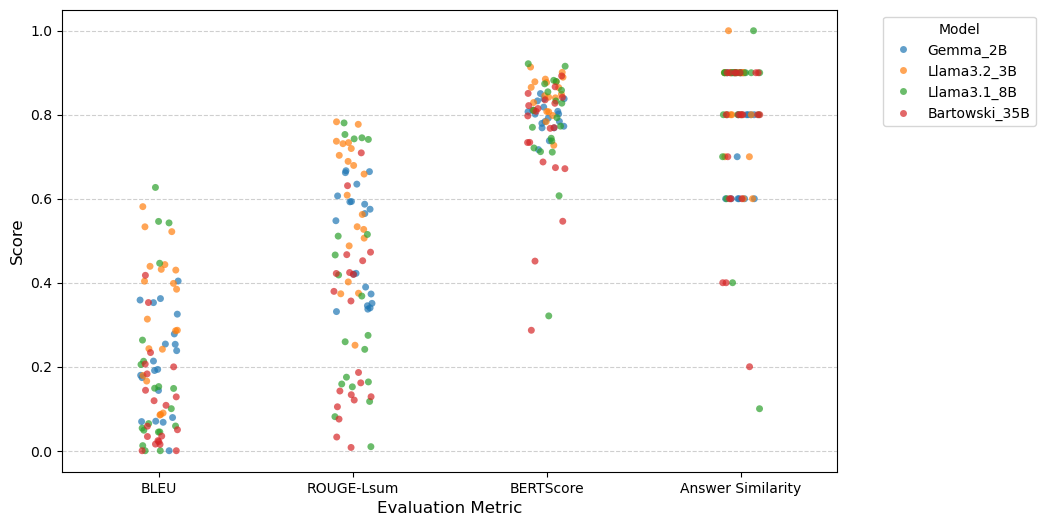

In [152]:
# Reshape DataFrame: Convert metric columns into a long format
score_data_raw_melted = score_data_raw.melt(id_vars=["model", "prompt_type", "text_complexity"], 
                     value_vars=evaluation_metrics,
                     var_name="Metric", 
                     value_name="Score")


# Scatterplot to show spread of scores
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=score_data_raw_melted,
    x="Metric",
    y="Score",
    hue="model",
    jitter=True, alpha=0.7)

# Formatting
plt.xlabel("Evaluation Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

In [137]:
for metric in evaluation_metrics:
    print(metric, score_data_raw[metric].mean().round(4))
    print(metric, score_data_raw[metric].std().__round__(4))

BLEU 0.2102
BLEU 0.1657
ROUGE-Lsum 0.4418
ROUGE-Lsum 0.2216
BERTScore 0.7879
BERTScore 0.1106
Answer Similarity 0.7812
Answer Similarity 0.1692


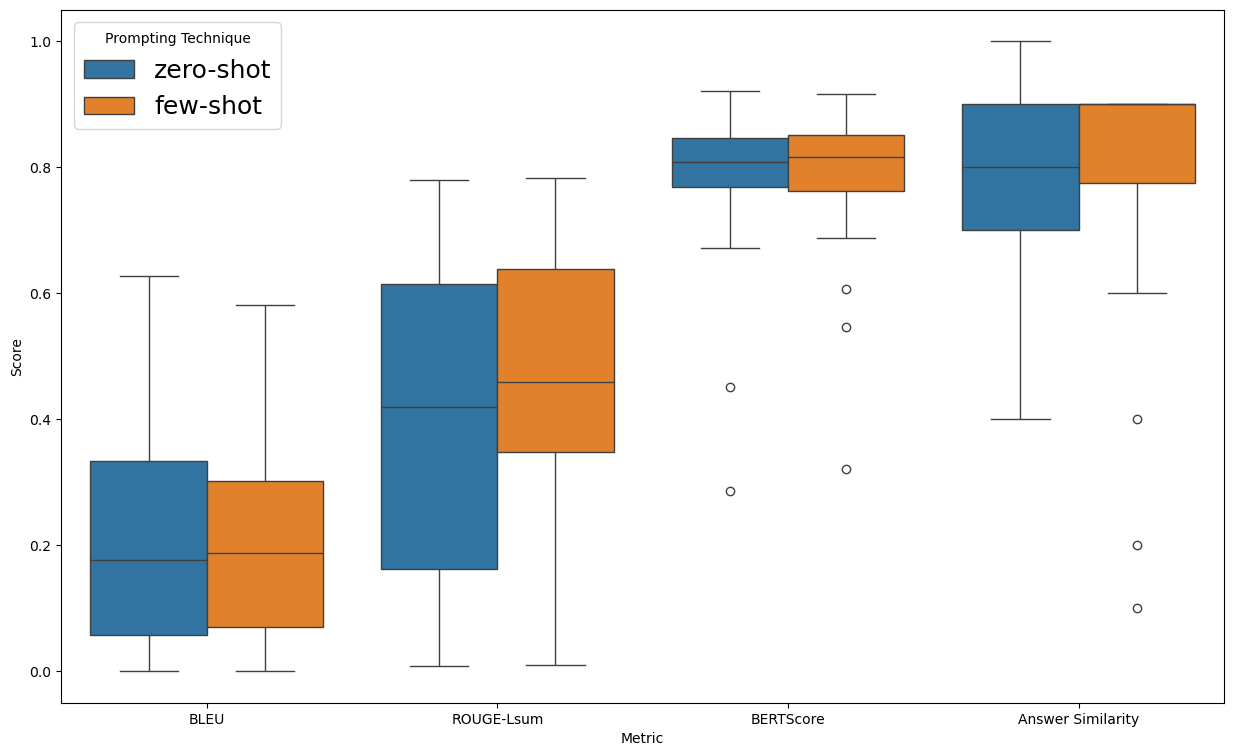

In [153]:
score_data_raw_melted = score_data_raw.melt(id_vars=["prompt_type"],
                                      value_vars=evaluation_metrics,
                                      var_name="Metric", value_name="Score")


# Create box plot that compares promting techniques per metric
plt.figure(figsize=(15, 9))
sns.boxplot(x="Metric",
            y="Score",
            hue="prompt_type",
            data=score_data_raw_melted,
            order=evaluation_metrics)

# Adjust labels and title
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Prompting Technique", prop={'size':18})

# Show plot
plt.show()

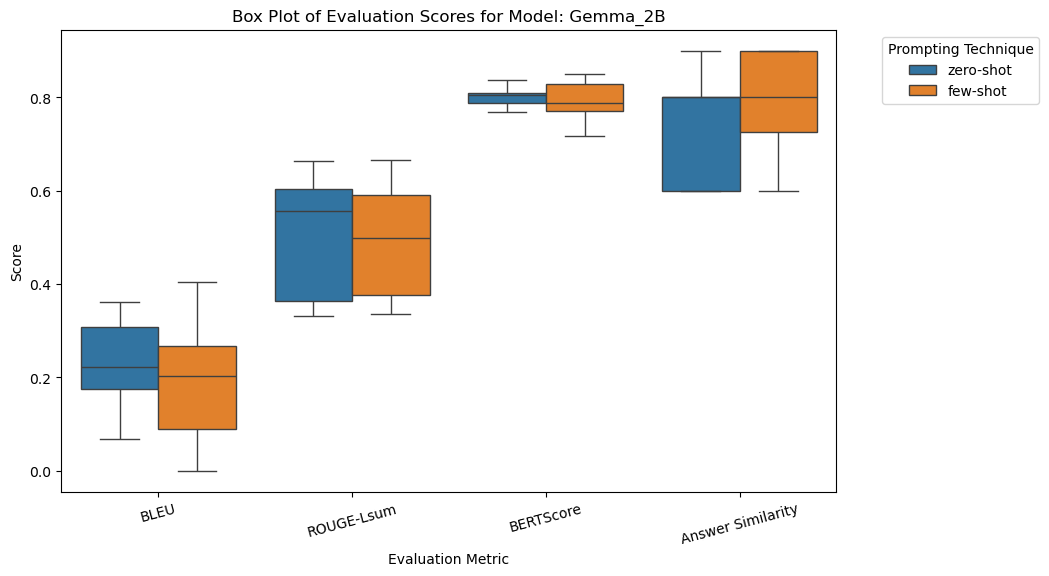

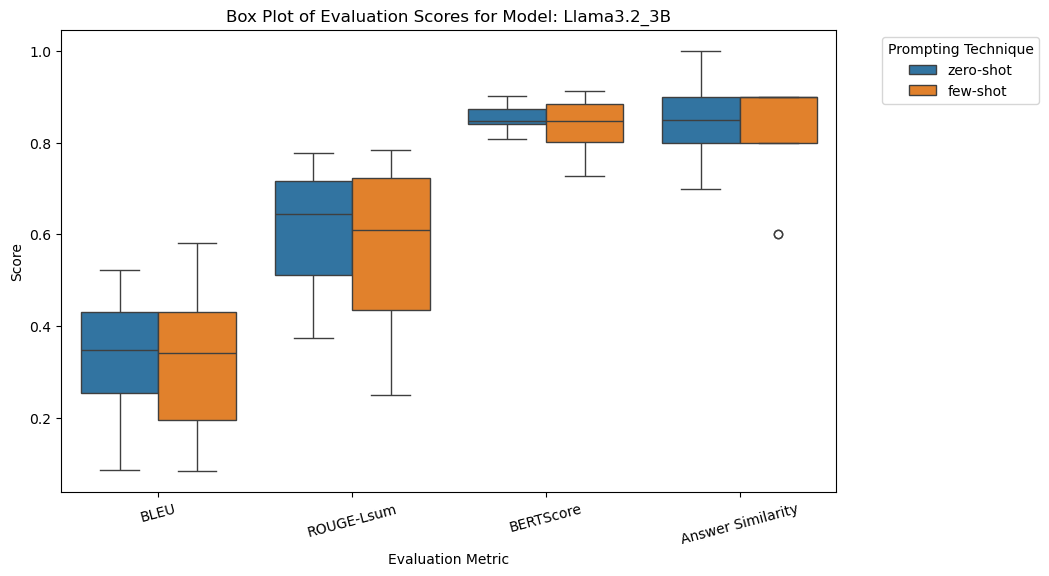

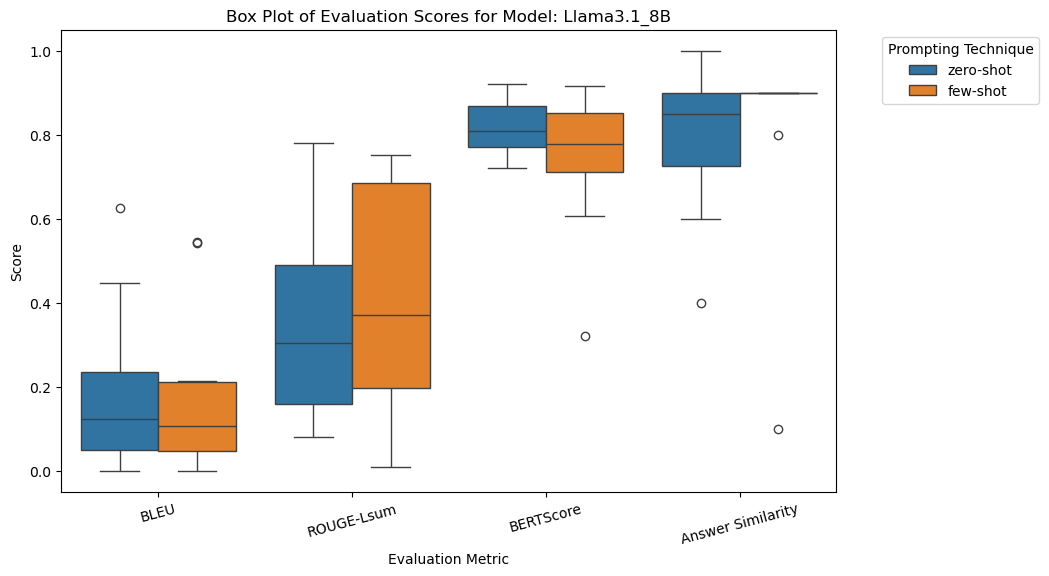

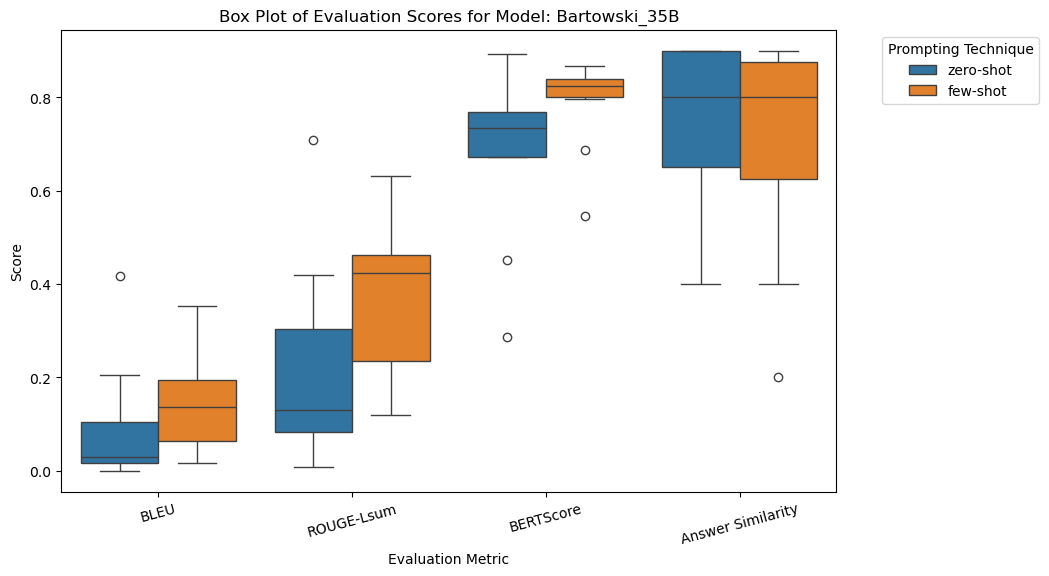

In [154]:
# Create one boxplot per model comparing how scores performed splitted by cleaned/raw dataset
models = ["Gemma_2B", "Llama3.2_3B", "Llama3.1_8B", "Bartowski_35B"]

# Create box plots per model
for model in models:
    plt.figure(figsize=(10, 6))

    # Filter data for the current model
    model_data = score_data_raw[score_data_raw["model"] == model]

    # Create boxplot with metric names on x-axis
    sns.boxplot(x="variable", y="value", hue="prompt_type",
                data=model_data.melt(id_vars=["prompt_type"], value_vars=evaluation_metrics))

    plt.title(f"Box Plot of Evaluation Scores for Model: {model}")
    plt.xlabel("Evaluation Metric")
    plt.ylabel("Score")
    plt.legend(title="Prompting Technique", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
    plt.xticks(rotation=15)  # Rotate labels for readability
    plt.show()

/var/folders/wz/qq9hjj691sn7xfkt71ch934m0000gn/T/ipykernel_98030/700108150.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)  # Rotate x-axis labels for readability
/var/folders/wz/qq9hjj691sn7xfkt71ch934m0000gn/T/ipykernel_98030/700108150.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)  # Rotate x-axis labels for readability
/var/folders/wz/qq9hjj691sn7xfkt71ch934m0000gn/T/ipykernel_98030/700108150.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)  # Rotate x-axis labels for readability
/var/folders/wz/qq9hjj691sn7xfkt71ch934m0000gn/T/ipykernel_98030/700108150.py:22: 

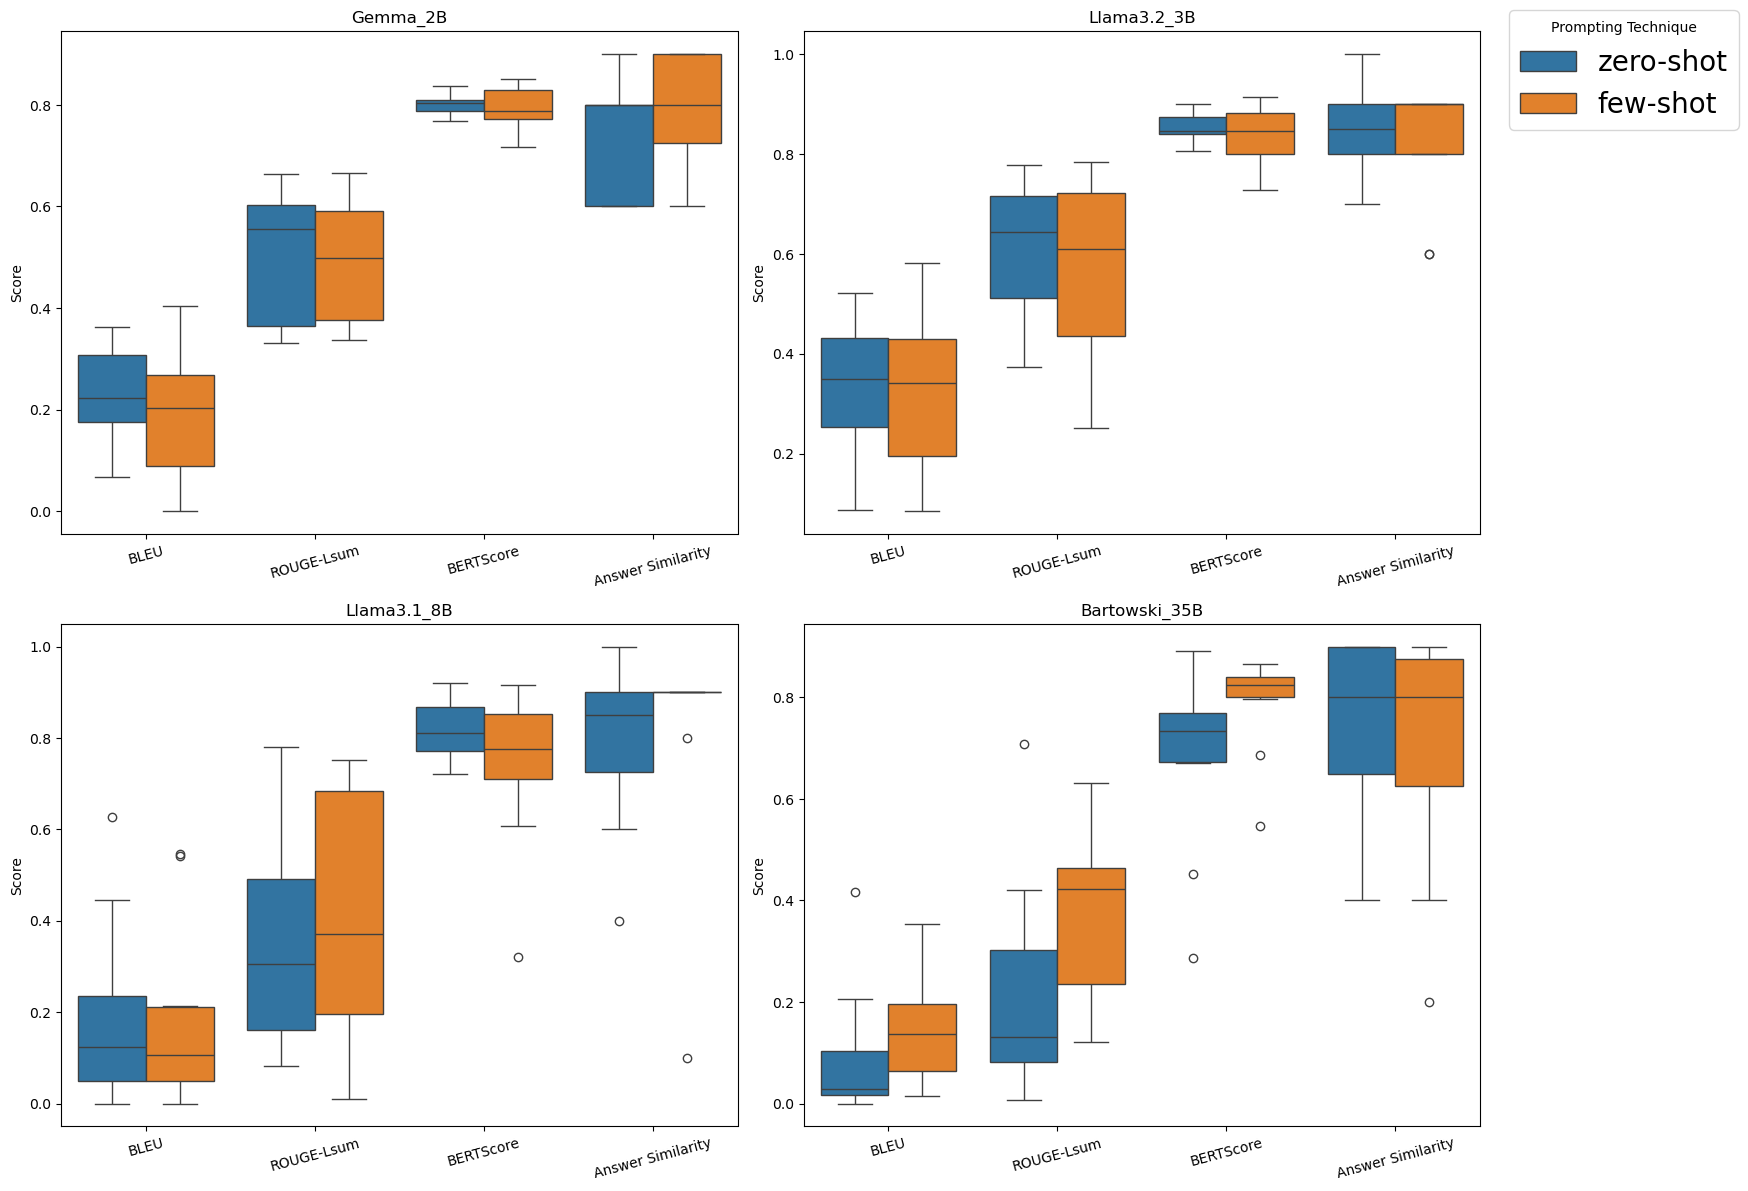

In [155]:
# Define models and set up subplots
models = ["Gemma_2B", "Llama3.2_3B", "Llama3.1_8B", "Bartowski_35B"]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2 rows, 2 columns

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through models and create subplots
for i, model in enumerate(models):
    ax = axes[i]  # Select subplot
    
    # Filter data for the current model
    model_data = score_data_raw[score_data_raw["model"] == model]
    # Create boxplot
    sns.boxplot(x="variable", y="value", hue="prompt_type",
                data=model_data.melt(id_vars=["prompt_type"], value_vars=evaluation_metrics),
                ax=ax)

    ax.set_title(f"{model}")
    ax.set_ylabel("Score")  # Keep y-axis labels
    ax.set_xlabel("")  # Remove x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)  # Rotate x-axis labels for readability

    # Remove individual legends
    ax.legend_.remove()

# Add one global legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from first plot
fig.legend(handles, labels, title="Prompting Technique", bbox_to_anchor=(1, 1), loc="upper left", prop={'size':20})

plt.tight_layout()

plt.show()


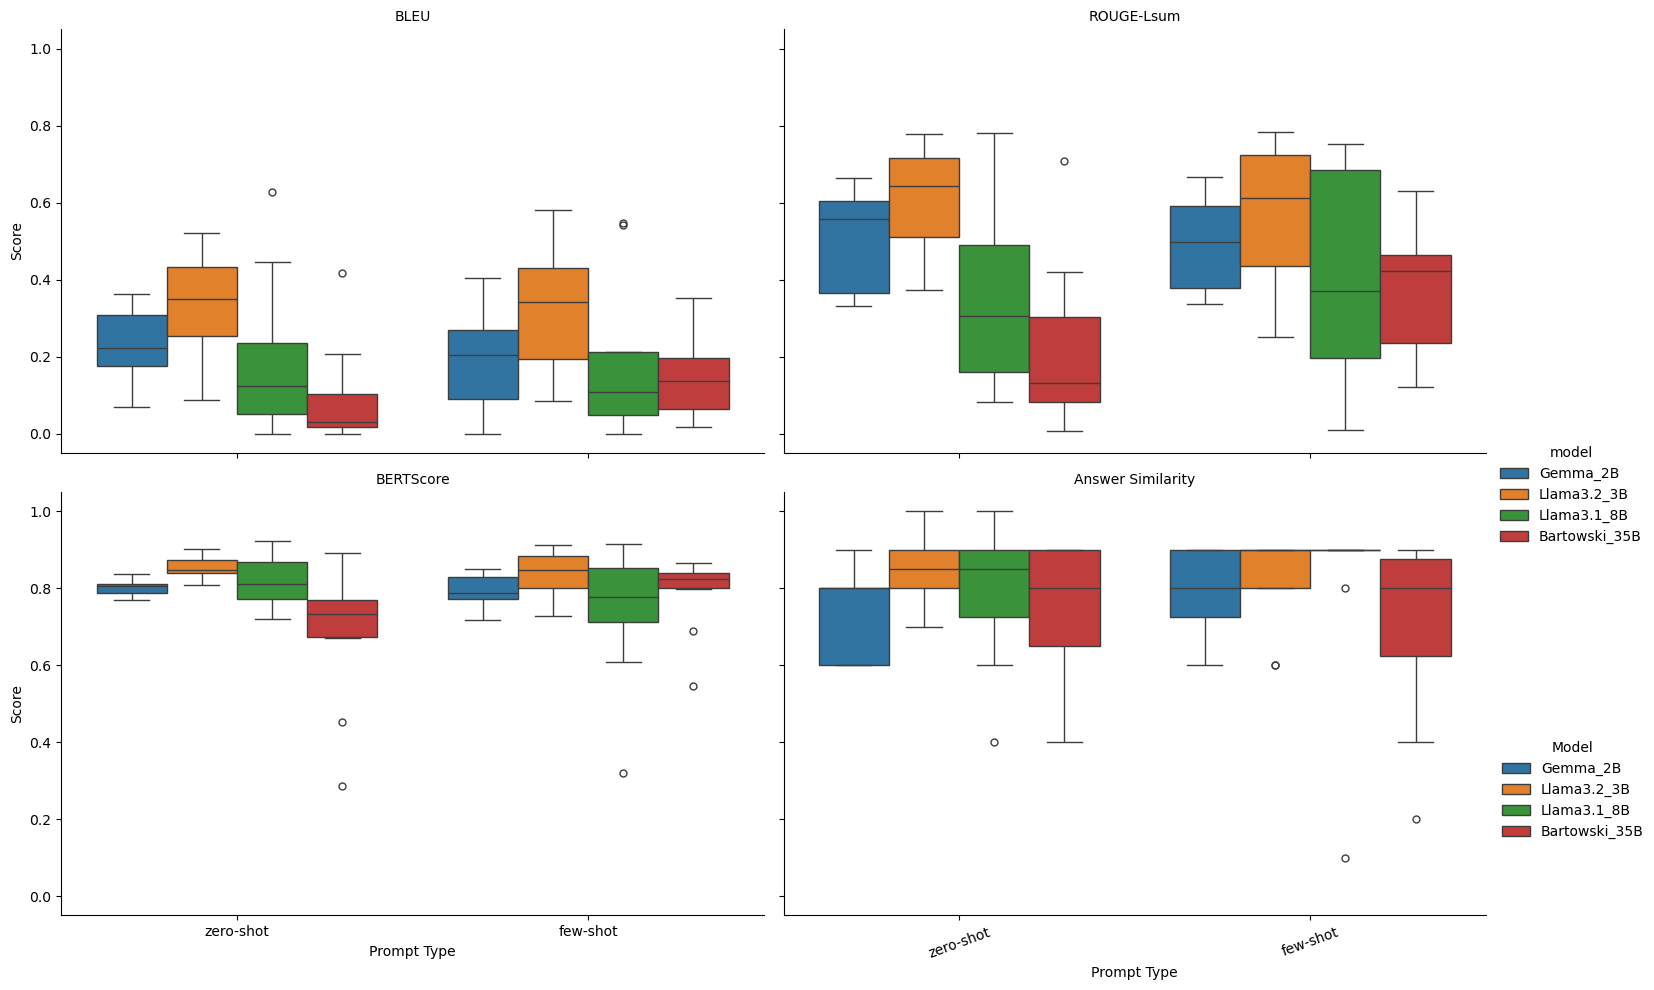

In [176]:
# Create one boxplot per metric that shows how each model performed on this metric splitted by prompting technique

# Reshape the dataframe for easier plotting
score_data_raw_melted = score_data_raw.melt(id_vars=["prompt_type", "model"], value_vars=evaluation_metrics,
                     var_name="Metric", value_name="Score")

# Create FacetGrid for grouped boxplots
g = sns.catplot(
    data=score_data_raw_melted,
    x="prompt_type",  # One-shot vs. Zero-shot on x-axis
    y="Score",
    hue="model",  # Different models as colors
    col="Metric",  # Create separate plots for each metric
    kind="box",
    height=5,
    aspect=1.2,
    col_wrap=2
)

# Adjust layout
g.set_axis_labels("Prompt Type", "Score")
g.set_titles("{col_name}")
plt.xticks(rotation=20)

# Move the legend outside the plot on the right side
g.add_legend(title="Model")
g._legend.set_bbox_to_anchor((1.1, 0.2))  # Move legend outside to the right

plt.tight_layout()
plt.show()

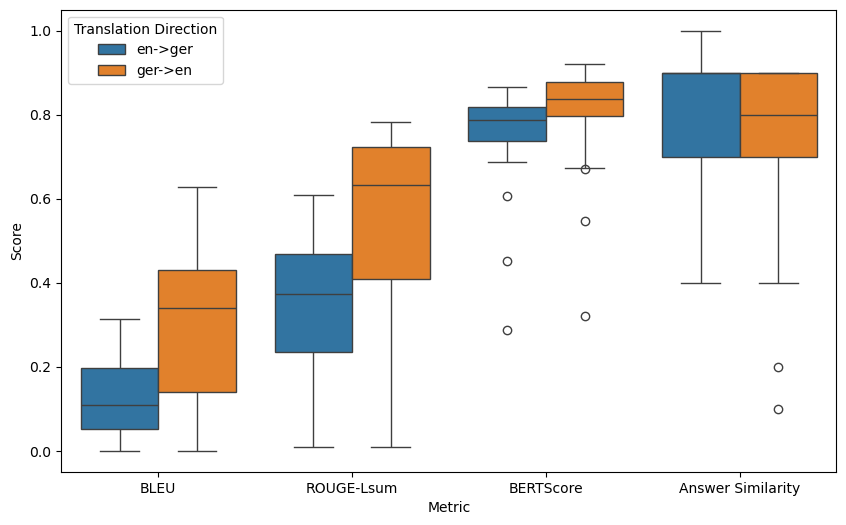

In [157]:
score_data_raw_melted = score_data_raw.melt(id_vars=["translation_direction"],
                                      value_vars=evaluation_metrics,
                                      var_name="Metric", value_name="Score")


# Create box plot comparing each metric splitted by translation direction
plt.figure(figsize=(10, 6))
sns.boxplot(x="Metric",
            y="Score",
            hue="translation_direction",
            data=score_data_raw_melted,
            order=evaluation_metrics)

# Adjust labels and title
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Translation Direction")

# Show plot
plt.show()

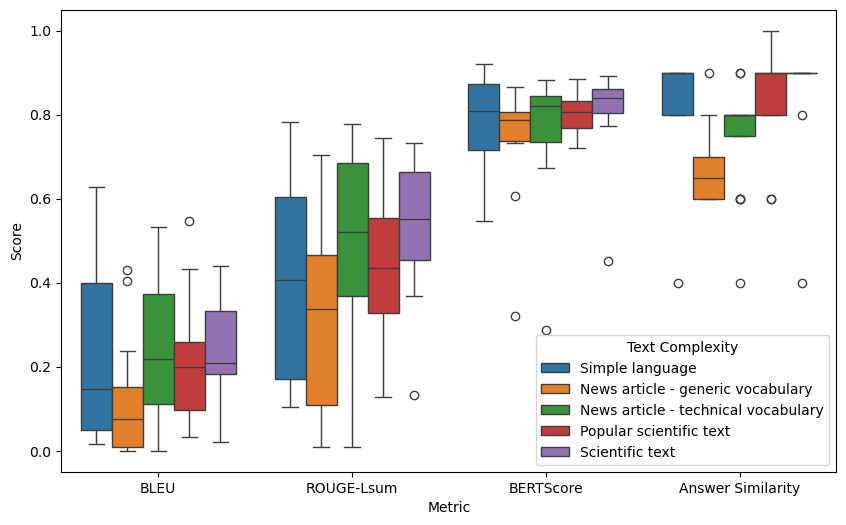

In [166]:
# Create box plot comparing each metric splitted by text complexity
plt.figure(figsize=(10, 6))
sns.boxplot(x="Metric",
            y="Score",
            hue="text_complexity",
            data=score_data_raw.melt(id_vars=["text_complexity"],
                                      value_vars=evaluation_metrics,
                                      var_name="Metric", value_name="Score"),
            order=evaluation_metrics)

# Adjust labels and title
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Text Complexity")
# Show plot
plt.show()

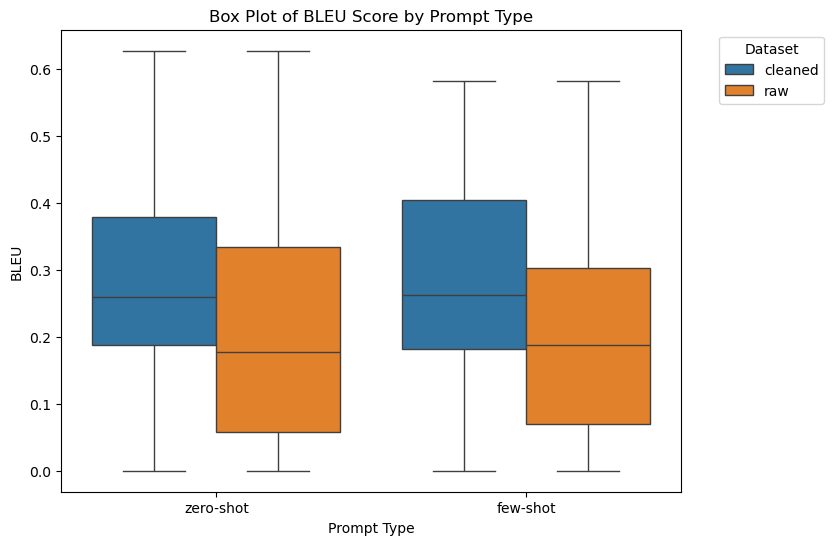

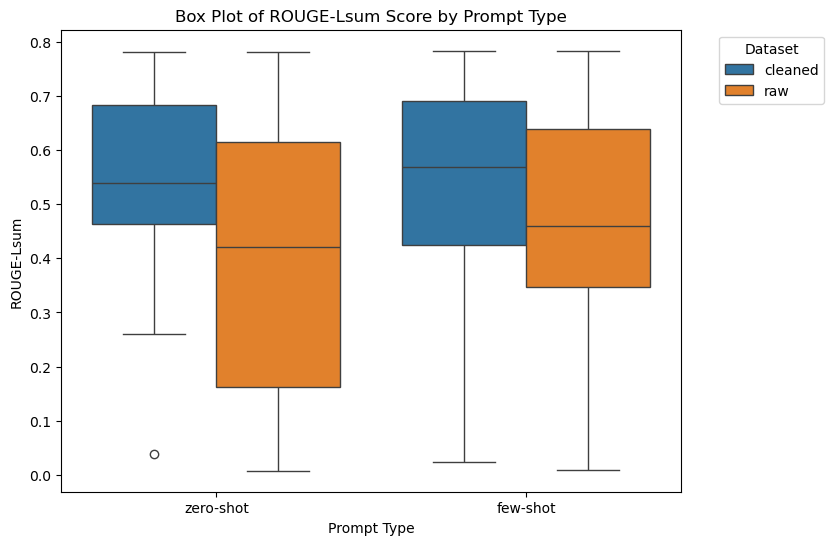

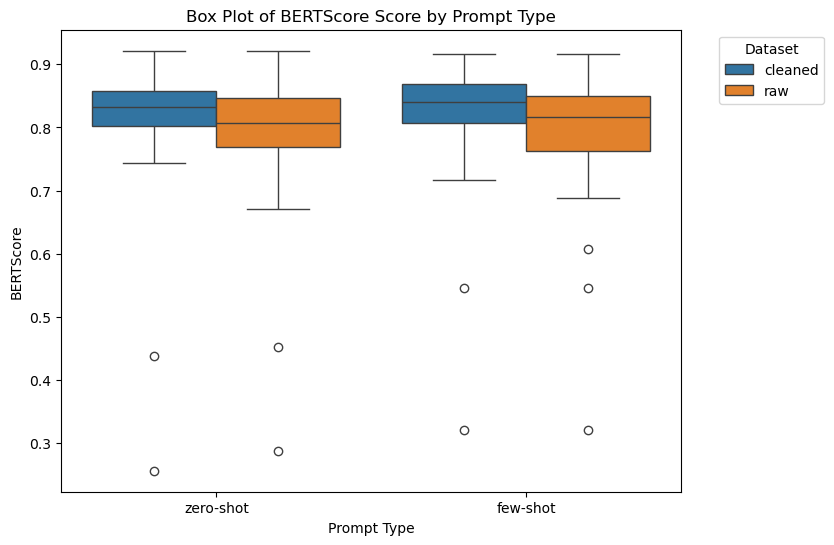

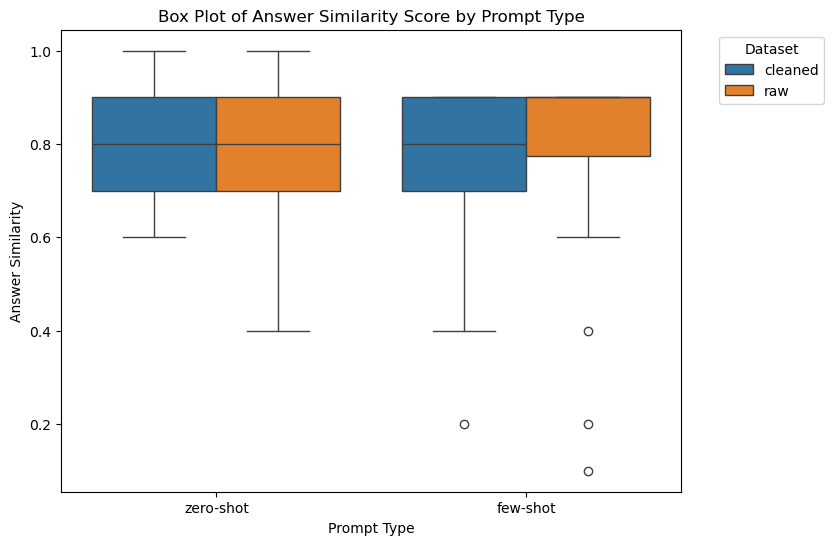

In [163]:
# Create one boxplot per metric comparing how prompting techniques performed splitted by cleaned/raw dataset
for metric in evaluation_metrics:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=score_data["prompt_type"], y=score_data[metric], hue=score_data["dataset"])
    plt.title(f"Box Plot of {metric} Score by Prompt Type")
    plt.xlabel("Prompt Type")
    plt.ylabel(metric)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

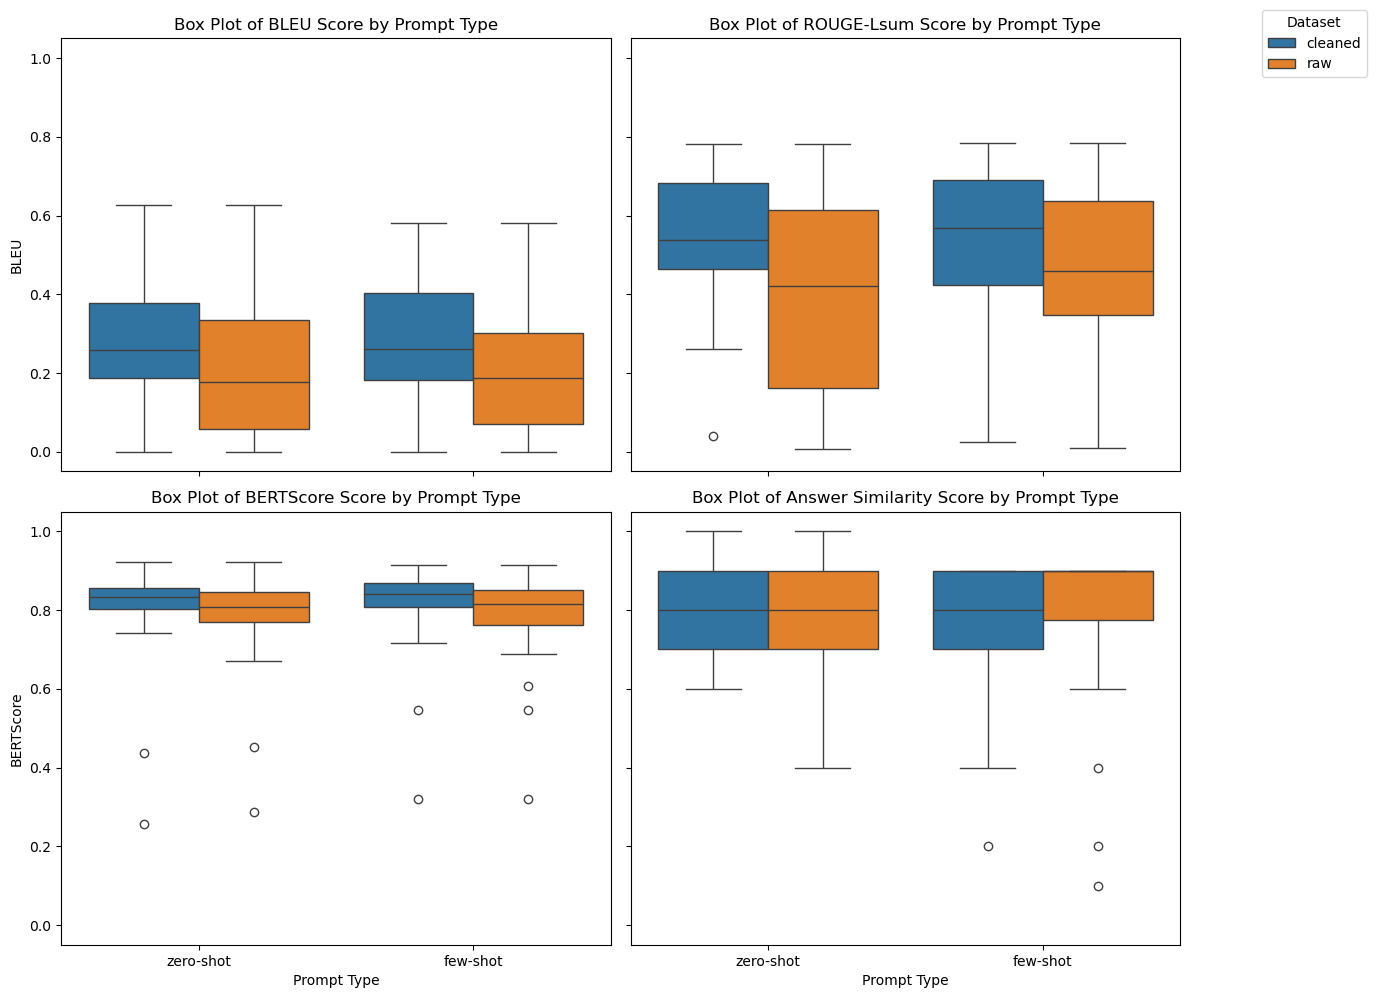

In [167]:
# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each metric and assign it to a subplot
for i, metric in enumerate(evaluation_metrics):
    ax = axes[i]  # Select subplot

    # Create boxplot
    sns.boxplot(x="prompt_type", y=metric, hue="dataset", data=score_data, ax=ax)

    # Set title and labels
    ax.set_title(f"Box Plot of {metric} Score by Prompt Type")
    ax.set_xlabel("Prompt Type")
    ax.set_ylabel(metric)

    # Remove individual legends from subplots
    ax.legend_.remove()

# Create one shared legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

# Show the final figure
plt.show()


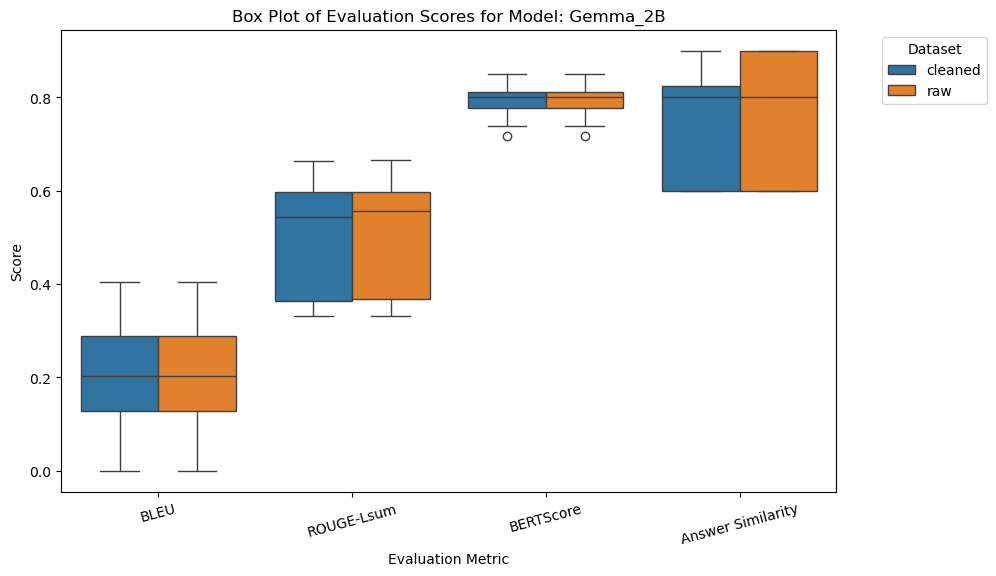

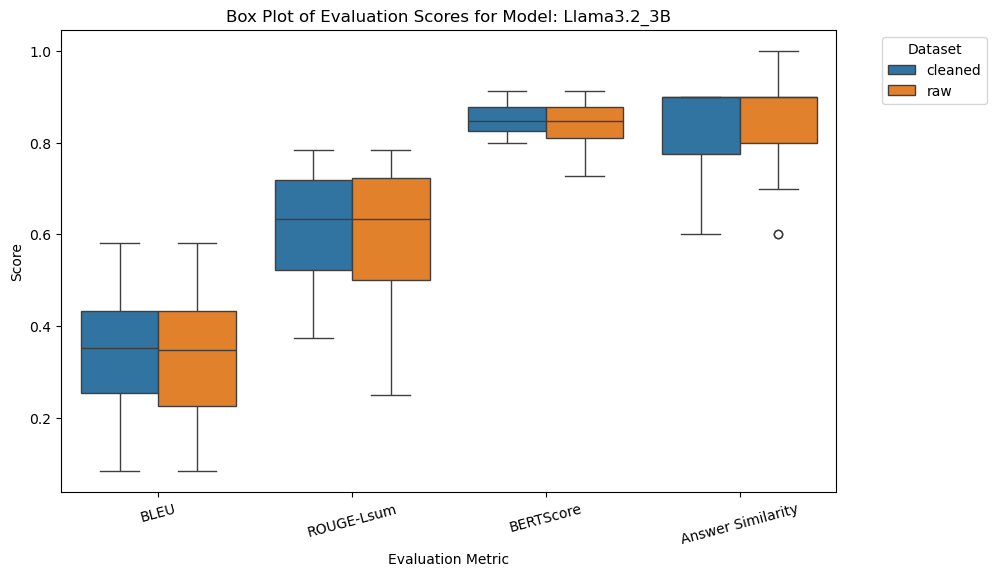

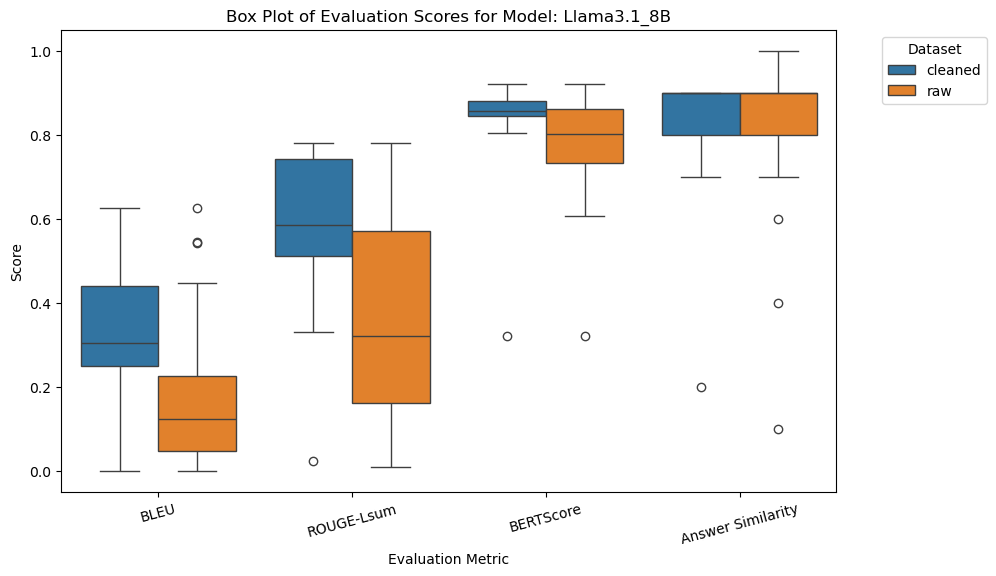

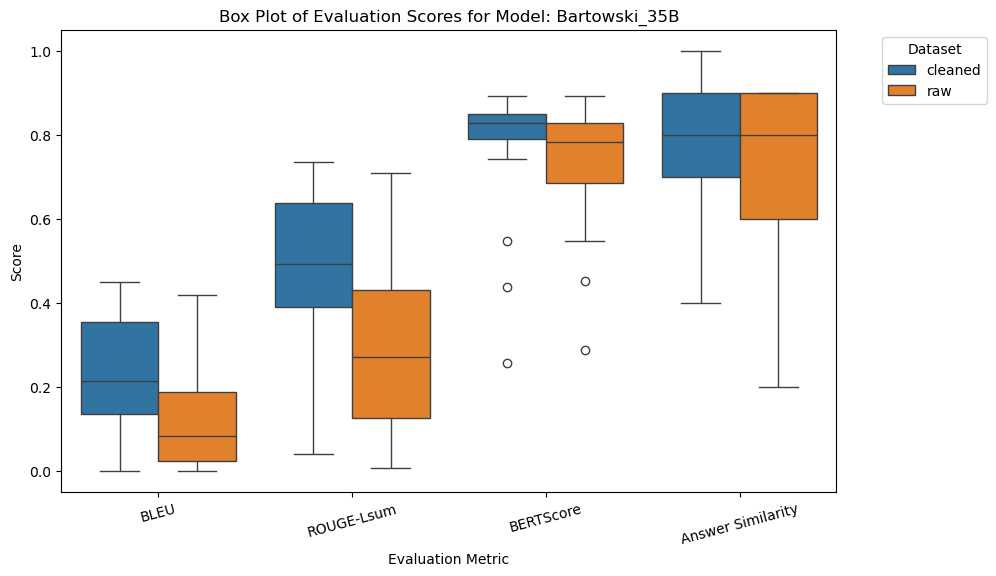

In [165]:
# Create one boxplot per model comparing how scores performed splitted by cleaned/raw dataset
score_data = score_data.sort_values(by=['model', 'prompt_type', 'dataset'])

for model in models:
    plt.figure(figsize=(10, 6))

    # Filter data for the current model
    model_data = score_data[score_data["model"] == model]

    # Create boxplot with metric names on x-axis
    sns.boxplot(x="variable", y="value", hue="dataset",
                data=model_data.melt(id_vars=["dataset"], value_vars=evaluation_metrics))

    plt.title(f"Box Plot of Evaluation Scores for Model: {model}")
    plt.xlabel("Evaluation Metric")
    plt.ylabel("Score")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
    plt.xticks(rotation=15)  # Rotate labels for readability
    plt.show()